In [42]:
import pandas as pd
import matplotlib.pyplot as plt 
import os

In [43]:
folders = ["result_sf1/", "result_sf2/", "result_sf5/"]
scales = ["sf1", "sf2", "sf5"]
variations = ["all", "dates_text", "dates", "no_index", "numbers_dates", "numbers_text", "numbers", "text", "default_index"]

In [44]:
folder = "result_sf1/"
file = "index_stats_numbers.csv"
kb_in_one_mb = 1024
bytes_in_one_mb = 1_048_576
mb_in_one_gb = 1024

In [45]:
df = pd.read_csv(folder+file)

In [46]:
df.dropna(inplace=True)

In [47]:
def to_mb(row):
   units = ["kB", "bytes", "GB"]
   if not any(unit in row for unit in units):
      return row
   
   splitted = row.split()
   number = float(splitted[0])
   
   if "kB" in row:
      mb = number / kb_in_one_mb
   elif "GB" in row:
      mb = number * mb_in_one_gb
   else: # bytes
      mb = number / bytes_in_one_mb
   
   return str(mb) + " MB"

In [48]:
def clean_mb_to_number(row):
   
   if "MB" not in row:
      return row
   
   row = row.replace("MB", "").strip()
   return float(row)

In [49]:
# columns that can contain kb
kb_columns = ["Total Size","Total Size of all Indexes", "Table Size", "Index Size"]
# Columns that 
mb_columns = ["Total Size MB","Total Size of all Indexes MB", "Table Size MB", "Index Size MB"]


In [50]:
def drop_and_convert_to_mb(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
   df = df.copy()
   for column in columns:
      df[column + " MB"] = df[column].apply(to_mb)
   dropped_df = df.drop(columns=columns)
   return dropped_df

def drop_mb_convert_to_float(df: pd.DataFrame, columns: list[str])-> pd.DataFrame:
   df = df.copy()
   for column in columns:
      df[column] = df[column].apply(clean_mb_to_number)
   return df

def get_table_info(df: pd.DataFrame)-> pd.DataFrame:
   table_info = df.drop_duplicates(subset=["Table Name"])
   return table_info.drop(columns=["Index Size MB", "Index Name"])

def clean_and_table_info(df : pd.DataFrame) -> pd.DataFrame:
   df = df.copy()
   df_nona = df.dropna()
   df_mb = drop_and_convert_to_mb(df_nona, kb_columns)
   df_mb_numbers = drop_mb_convert_to_float(df_mb, mb_columns)
   table_info = get_table_info(df_mb_numbers)
   return table_info

In [51]:
table_info = clean_and_table_info(df)

In [52]:
table_info

,Table Name,Estimated table row count,Total Size MB,Total Size of all Indexes MB,Table Size MB
0,customer,150000.0,39.000000,11.000000,28.000000
4,lineitem,6001088.0,1841.000000,961.000000,880.000000
14,nation,25.0,0.054688,0.046875,0.007812
17,orders,1500000.0,325.000000,121.000000,204.000000
21,part,200000.0,47.000000,14.000000,32.000000
25,partsupp,800000.0,209.000000,72.000000,137.000000
31,region,5.0,0.039062,0.031250,0.007812
33,supplier,10000.0,2.562500,0.789062,1.742188


In [53]:
def get_total_size_sum(df: pd.DataFrame):
   return df["Total Size MB"].sum()

def get_table_size_sum(df: pd.DataFrame):
   return df["Table Size MB"].sum()

def get_sum(df: pd.DataFrame, column: str):
   return df[column].sum()

In [54]:
table_size = get_table_size_sum(table_info)
total_size = get_total_size_sum(table_info)
index_size = get_sum(table_info, "Total Size of all Indexes MB")
print(table_size, total_size)

1282.7578125 2463.65625


In [55]:
table_info

,Table Name,Estimated table row count,Total Size MB,Total Size of all Indexes MB,Table Size MB
0,customer,150000.0,39.000000,11.000000,28.000000
4,lineitem,6001088.0,1841.000000,961.000000,880.000000
14,nation,25.0,0.054688,0.046875,0.007812
17,orders,1500000.0,325.000000,121.000000,204.000000
21,part,200000.0,47.000000,14.000000,32.000000
25,partsupp,800000.0,209.000000,72.000000,137.000000
31,region,5.0,0.039062,0.031250,0.007812
33,supplier,10000.0,2.562500,0.789062,1.742188


In [56]:
columns = ["scale", "index", "index_size", "table_size", "total_size" ]
data = pd.DataFrame(columns=columns)


In [57]:
for scale in scales:
   for variation in variations:
      path = "result_" + scale + "/" + "index_stats_" + variation + ".csv"
      df = pd.read_csv(path)
      table_info = clean_and_table_info(df)

      table_size_sum = get_table_size_sum(table_info)
      index_size_sum = get_sum(table_info, "Total Size of all Indexes MB")
      total_size_sum = get_total_size_sum(table_info)
      data.loc[len(data)] = [scale, variation, index_size_sum, table_size_sum, total_size_sum]

      print(f"{folder + variation} - table: {table_size_sum} + index: {index_size_sum} = total_size {total_size_sum}")


result_sf1/all - table: 1282.7578125 + index: 2049.0859375 = total_size 3332.875
result_sf1/dates_text - table: 1282.7578125 + index: 1431.8515625 = total_size 2715.640625
result_sf1/dates - table: 1282.7578125 + index: 694.7265625 = total_size 1978.421875
result_sf1/no_index - table: 1282.7578125 + index: 185.8046875 = total_size 1470.0546875
result_sf1/numbers_dates - table: 1282.7578125 + index: 1311.8671875 = total_size 2596.65625
result_sf1/numbers_text - table: 1282.7578125 + index: 1917.0859375 = total_size 3200.875
result_sf1/numbers - table: 1282.7578125 + index: 1179.8671875 = total_size 2463.65625
result_sf1/text - table: 1282.7578125 + index: 1299.8515625 = total_size 2582.640625
result_sf1/default_index - table: 1282.7578125 + index: 694.7265625 = total_size 1978.421875
result_sf1/all - table: 2564.703125 + index: 4071.8671875 = total_size 6636.6015625
result_sf1/dates_text - table: 2564.703125 + index: 2837.421875 = total_size 5403.15625
result_sf1/dates - table: 2564.703

In [58]:
sf1 = data[data["scale"]=="sf1"]
sf2 = data[data["scale"]=="sf2"]
sf5 = data[data["scale"]=="sf5"]

In [59]:
sf5

,scale,index,index_size,table_size,total_size
18,sf5,all,10086.140625,6410.703125,16076.156250
19,sf5,dates_text,7001.140625,6410.703125,13414.156250
20,sf5,dates,3456.609375,6410.703125,9868.093750
21,sf5,no_index,928.117188,6410.703125,7341.851562
22,sf5,numbers_dates,6541.695312,6410.703125,12954.093750
23,sf5,numbers_text,9438.140625,6410.703125,16026.156250
24,sf5,numbers,5892.695312,6410.703125,12305.093750
25,sf5,text,6352.140625,6410.703125,12765.156250
26,sf5,default_index,3456.609375,6410.703125,9868.093750


In [60]:
if not os.path.exists("imgs"):
   os.makedirs("imgs")

In [61]:
plt.rcParams.update({'font.size': 12})  # Set default font size for all text
def create_barplot(data:pd.DataFrame, scale: str):
   plt.figure(figsize=(8,8))
   sf = data[data["scale"]==scale]
   sf_sorted = sf.sort_values(by="index_size", ascending=False)
   axes = sf_sorted.plot(kind='bar', y="index_size")
   axes.set_xticklabels(sf_sorted["index"], rotation=45, ha='right')
   axes.get_yticklabels()
   axes.spines["top"].set_visible(False)
   axes.spines["left"].set_visible(False)
   axes.spines["right"].set_visible(False)

   axes.set_xlabel("Index")
   axes.set_ylabel("Storage overhead (MB)")
   axes.set_title(f"Storage overhead for indexing scale {scale.replace("sf", "")} GB", fontweight="bold")
   plt.tight_layout()
   plt.savefig(f"imgs/index_size_{scale}",dpi=300)

<Figure size 800x800 with 0 Axes>

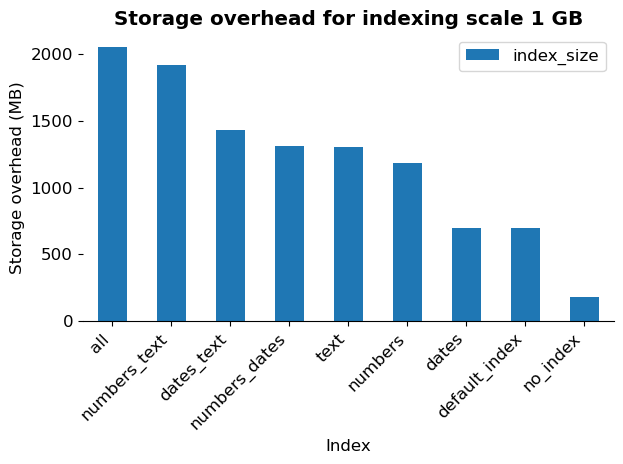

In [62]:
create_barplot(data, "sf1")

<Figure size 800x800 with 0 Axes>

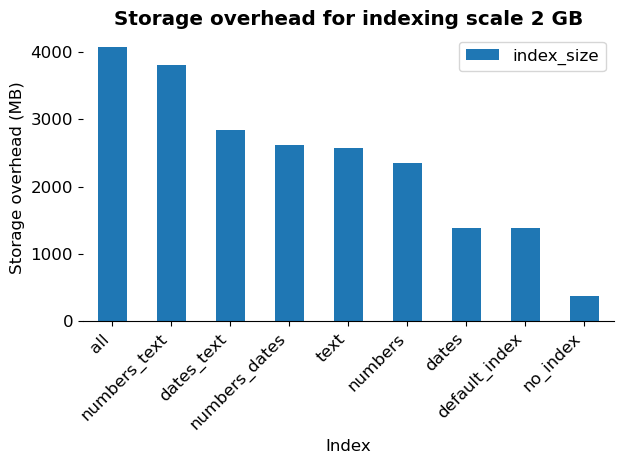

In [63]:
create_barplot(data, "sf2")


<Figure size 800x800 with 0 Axes>

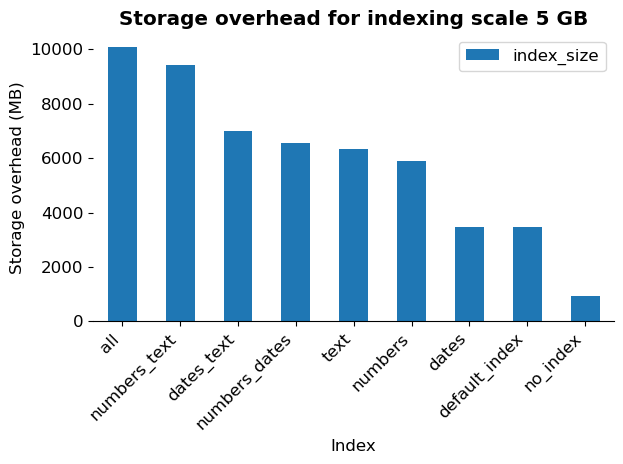

In [64]:
create_barplot(data, "sf5")
